<a href="https://colab.research.google.com/github/duypham01/DiscretePINN/blob/main/ChorinInverse/ChorinInverse_PINN_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from collections import OrderedDict

import numpy as np
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import warnings
import time
from torch.autograd import grad
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

warnings.filterwarnings('ignore')

np.random.seed(1234)

In [ ]:
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()

        # parameters
        self.depth = len(layers) - 1

        # set up layer order dict
        self.activation = torch.nn.Tanh

        layer_list = list()
        for i in range(self.depth - 1):
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))

        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)

        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

In [ ]:
class PhysicsInformedNN():
    def __init__(self, X, u, v, layers):

        # data
        self.t = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        self.x = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        self.y = torch.tensor(X[:, 2:3], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        self.v = torch.tensor(v).float().to(device)

        # settings
        self.lambda_1 = torch.tensor([0.0], requires_grad=True).to(device)

        self.lambda_1 = torch.nn.Parameter(self.lambda_1)

        # deep neural networks
        self.dnn = DNN(layers).to(device)
        self.dnn.register_parameter('lambda_1', self.lambda_1)

        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=1.0,
            max_iter=20,
            history_size=50,
            tolerance_grad=1e-5,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )

        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.iter = 0
        self.losses_hist = []
        self.lambda_hist = []

    def net_u(self, x, y, t):
        outputs = self.dnn(torch.cat([t,x,y], dim=1))
        u, v, p = outputs[:, 0], outputs[:, 1], outputs[:, 2]
        return u, v, p

    def net_f(self, x, y, t):
        """ The pytorch autograd version of calculating residual """
        lambda_1 = self.lambda_1
        u, v, p = self.net_u(x, y, t)

        # u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        # u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        # u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]

        # v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
        # v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
        # v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]

        # p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), retain_graph=True, create_graph=True)[0]
        # p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), retain_graph=True, create_graph=True)[0]

        # u_xx = grad(u_x, x, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
        # u_yy = grad(u_y, y, grad_outputs=torch.ones_like(u_y), retain_graph=True, create_graph=True)[0]
        # v_xx = grad(v_x, x, grad_outputs=torch.ones_like(v_x), retain_graph=True, create_graph=True)[0]
        # v_yy = grad(v_y, y, grad_outputs=torch.ones_like(v_y), retain_graph=True, create_graph=True)[0]

        u_t, u_x, u_y = torch.autograd.grad(outputs=u, inputs=[t, x, y],
                                            grad_outputs=torch.ones_like(u),
                                            retain_graph=True, create_graph=True)
        v_t, v_x, v_y = torch.autograd.grad(outputs=v, inputs=[t, x, y],
                                            grad_outputs=torch.ones_like(v),
                                            retain_graph=True, create_graph=True)
        p_x = torch.autograd.grad(outputs=p, inputs=x, grad_outputs=torch.ones_like(p),
                                  retain_graph=True, create_graph=True)[0]
        p_y = torch.autograd.grad(outputs=p, inputs=y, grad_outputs=torch.ones_like(p),
                                  retain_graph=True, create_graph=True)[0]

        u_xx = torch.autograd.grad(outputs=u_x, inputs=x, grad_outputs=torch.ones_like(u_x),
                                   retain_graph=True, create_graph=True)[0]
        u_yy = torch.autograd.grad(outputs=u_y, inputs=y, grad_outputs=torch.ones_like(u_y),
                                   retain_graph=True, create_graph=True)[0]
        v_xx = torch.autograd.grad(outputs=v_x, inputs=x, grad_outputs=torch.ones_like(v_x),
                                   retain_graph=True, create_graph=True)[0]
        v_yy = torch.autograd.grad(outputs=v_y, inputs=y, grad_outputs=torch.ones_like(v_y),
                                   retain_graph=True, create_graph=True)[0]

        f_u = u_t - lambda_1*(u_xx + u_yy) + u*u_x + v*u_y + p_x
        f_v = v_t - lambda_1*(v_xx + v_yy) + u*v_x + v*v_y + p_y
        div_u = u_x + v_y

        return f_u, f_v, div_u

    def loss_func(self):
        start_epoch = time.time()
        u_pred, v_pred, _ = self.net_u(self.x, self.y, self.t)
        f_u, f_v, div_u = self.net_f(self.x, self.y, self.t)

        mse_loss = torch.nn.MSELoss()
        loss = mse_loss(f_u, torch.zeros_like(f_u)) + mse_loss(f_v, torch.zeros_like(f_v)) + \
            mse_loss(div_u, torch.zeros_like(div_u)) + mse_loss(u_pred, self.u) + mse_loss(v_pred, self.v)

        self.optimizer.zero_grad()
        loss.backward()

        self.iter += 1
        self.losses_hist.append(loss.item())
        self.lambda_hist.append(self.lambda_1.item())
        print("Epoch [%d], Loss: %.4f, Lambda: %.4f, Time: %.4fs" % (self.iter, loss.item(), self.lambda_1.item(), time.time()-start_epoch))

        return loss

    def train(self, nIter_Adam, nIter_Lbfgs):
        self.dnn.train()
        for epoch in range(nIter_Adam):
            start_epoch = time.time()

            u_pred, v_pred, _ = self.net_u(self.x, self.y, self.t)
            f_u, f_v, div_u = self.net_f(self.x, self.y, self.t)

            mse_loss = torch.nn.MSELoss()
            loss = mse_loss(f_u, torch.zeros_like(f_u)) + mse_loss(f_v, torch.zeros_like(f_v)) + \
                    mse_loss(div_u, torch.zeros_like(div_u)) + mse_loss(u_pred, self.u) + mse_loss(v_pred, self.v)

            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()

            self.losses_hist.append(loss.item())
            self.lambda_hist.append(self.lambda_1.item())

            print("Epoch Adam [%d], Loss: %.4f, Lambda: %.4f, Time: %.4fs" % (epoch, loss.item(), self.lambda_1.item(), time.time()-start_epoch))

        for epoch in range(nIter_Lbfgs):
            self.optimizer.step(self.loss_func)

    def predict(self, X):
        t = torch.tensor(X[:, 0:1]).float().to(device)
        x = torch.tensor(X[:, 1:2]).float().to(device)
        y = torch.tensor(X[:, 2:3]).float().to(device)

        self.dnn.eval()
        u, v, p = self.net_u(x, y, t)
        return u, v, p

In [ ]:
def plot_loss(losses, ylabel):
    epochs = len(losses)
    x_epochs = np.arange(1, epochs + 1)

    plt.figure()
    plt.plot(x_epochs, losses, color='blue')
    plt.xlabel('Iteration')
    plt.ylabel(ylabel)
    plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
    plt.show()

def plot_streamlines(model, delta_x, t_value):
    # Define constants
    x = np.arange(0, 1 + delta_x, delta_x)
    y = np.arange(0, 1 + delta_x, delta_x)
    X, Y = np.meshgrid(x, y)
    t = np.full_like(X, t_value)
    grid_points = np.column_stack([t.ravel(), X.ravel(), Y.ravel()])

    # Model predictions at grid points
    # grid_points_tensor = torch.tensor(grid_points, dtype=torch.float32).to(device)
    u_pred, v_pred, _ = model.predict(grid_points)
    u = u_pred.detach().cpu().numpy().reshape(X.shape)
    v = v_pred.detach().cpu().numpy().reshape(X.shape)

    # Plot streamlines
    plt.figure(figsize=(6, 6))
    plt.streamplot(X, Y, u, v, density=1, color='b')

    # Customize plot
    plt.title(f'Streamlines at t = {t_value}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

In [ ]:
# Step 1: Define the exact solution and known parameters
def exact_solution(t, x, y, lam=0.01):
    u = -np.cos(np.pi * x) * np.sin(np.pi * y) * np.exp(-2 * np.pi**2 * t * lam)
    v = np.sin(np.pi * x) * np.cos(np.pi * y) * np.exp(-2 * np.pi**2 * t * lam)
    return u, v

In [ ]:
# Step 2: Generate training data based on the exact solution
def generate_data(t_samples, x_samples, y_samples, lam=0.01):
    data = []
    for t in t_samples:
        for x in x_samples:
            for y in y_samples:
                u, v = exact_solution(t, x, y, lam)
                # Compute placeholders for derivatives (initialize to zeros)
                u_t, v_t, u_x, u_y, v_x, v_y, u_xx, u_yy, v_xx, v_yy = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
                data.append([t, x, y, u, v, u_t, v_t, u_x, u_y, v_x, v_y, u_xx, u_yy, v_xx, v_yy])
    return np.array(data, dtype=np.float32)

delta_y = 0.05
delta_x = 0.05
delta_t = 0.2
# Define space and time discretization
t_samples = np.arange(0, 7.0+delta_t, delta_t)
x_samples = np.arange(0, 1.0+delta_x, delta_x)
y_samples = np.arange(0, 1.0+delta_x, delta_x)
data = generate_data(t_samples, x_samples, y_samples, lam=0.01)
print(data)
print(data.shape)

[[0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.05 ... 0.   0.   0.  ]
 [0.   0.   0.1  ... 0.   0.   0.  ]
 ...
 [7.   1.   0.9  ... 0.   0.   0.  ]
 [7.   1.   0.95 ... 0.   0.   0.  ]
 [7.   1.   1.   ... 0.   0.   0.  ]]
(15876, 15)


In [ ]:
# CUDA support
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [ ]:
print(device)

cuda


Epoch [1], Loss: 0.2738, Lambda: 0.0000, Time: 0.2859s
Epoch [2], Loss: 0.2137, Lambda: -0.0000, Time: 0.2778s
Epoch [3], Loss: 0.1740, Lambda: -0.0001, Time: 0.2765s
Epoch [4], Loss: 0.1732, Lambda: -0.0001, Time: 0.2771s
Epoch [5], Loss: 0.1724, Lambda: -0.0002, Time: 0.2774s
Epoch [6], Loss: 0.1682, Lambda: -0.0006, Time: 0.2773s
Epoch [7], Loss: 0.1626, Lambda: -0.0013, Time: 0.2775s
Epoch [8], Loss: 0.2207, Lambda: -0.0040, Time: 0.2780s
Epoch [9], Loss: 0.1549, Lambda: -0.0023, Time: 0.2766s
Epoch [10], Loss: 0.1513, Lambda: -0.0027, Time: 0.2764s
Epoch [11], Loss: 0.1471, Lambda: -0.0027, Time: 0.2774s
Epoch [12], Loss: 0.1278, Lambda: -0.0038, Time: 0.2766s
Epoch [13], Loss: 0.1022, Lambda: -0.0053, Time: 0.2767s
Epoch [14], Loss: 0.1407, Lambda: -0.0076, Time: 0.2778s
Epoch [15], Loss: 0.0956, Lambda: -0.0058, Time: 0.2787s
Epoch [16], Loss: 0.0934, Lambda: -0.0073, Time: 0.2766s
Epoch [17], Loss: 0.0938, Lambda: -0.0076, Time: 0.2762s
Epoch [18], Loss: 0.0911, Lambda: -0.0075

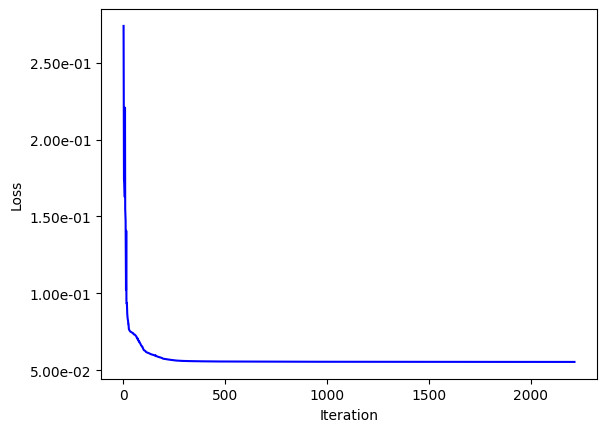

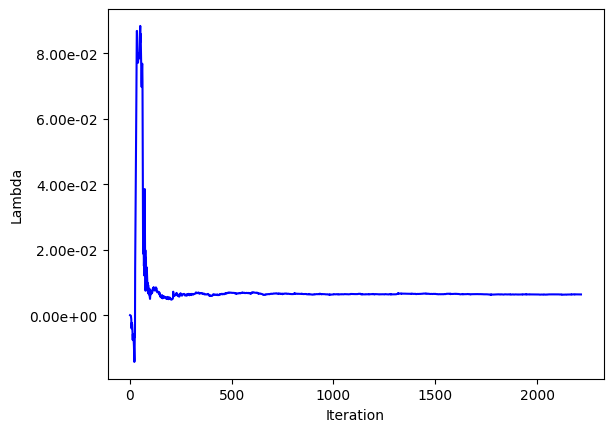

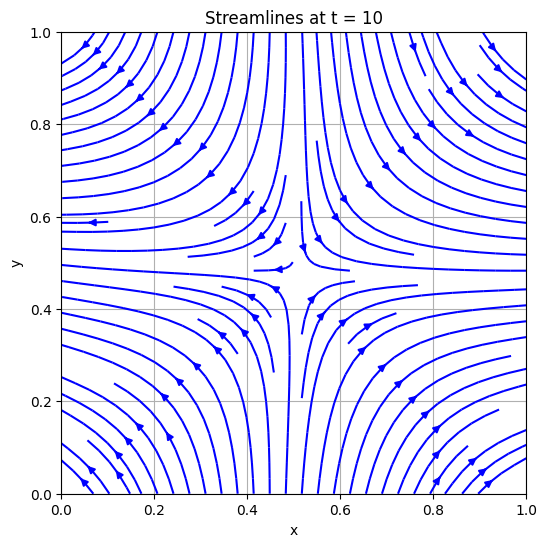

In [ ]:

layers = [3, 16, 16, 16, 16, 16, 3]
X_train = data[:,0:3]
U = data[:,3]
V = data[:,4]

# training
model = PhysicsInformedNN(X_train, U, V, layers)
model.train(0, 100)

# Test data generation
t_samples = np.arange(7.0, 10.0+delta_t, delta_t)
x_samples = np.arange(0, 1.0 + delta_x, delta_x)
y_samples = np.arange(0, 1.0 + delta_x, delta_x)
data_test = generate_data(t_samples, x_samples, y_samples, lam=0.01)

# Model predictions
# inputs = torch.tensor(data_test[:, :3], dtype=torch.float32, requires_grad=False).to(device)
u_pred, v_pred, _ = model.predict(data_test[:, :3])
# u_pred = pred_uvp[:, 0]
# v_pred = pred_uvp[:, 1]

u_test = torch.tensor(data_test[:, 3], dtype=torch.float32, requires_grad=False).to(device)
v_test = torch.tensor(data_test[:, 4], dtype=torch.float32, requires_grad=False).to(device)
# Calculate L2 error
mse_loss = torch.nn.MSELoss()
L2 = mse_loss(u_pred, u_test) + mse_loss(v_pred ,v_test)

print("L2 =", L2)
print("lambda = ", model.lambda_1)

# Plot loss history
plot_loss(model.losses_hist, ylabel='Loss')

# Plot lambda history
plot_loss(model.lambda_hist, ylabel='Lambda')

# Plot streamlines
plot_streamlines(model, delta_x, t_value=10)

Epoch Adam [0], Loss: 0.0555, Lambda: 0.0061, Time: 0.2934s
Epoch Adam [1], Loss: 0.0555, Lambda: 0.0061, Time: 0.2791s
Epoch Adam [2], Loss: 0.0555, Lambda: 0.0061, Time: 0.2788s
Epoch Adam [3], Loss: 0.0555, Lambda: 0.0061, Time: 0.2791s
Epoch Adam [4], Loss: 0.0555, Lambda: 0.0062, Time: 0.2789s
Epoch Adam [5], Loss: 0.0555, Lambda: 0.0062, Time: 0.2784s
Epoch Adam [6], Loss: 0.0555, Lambda: 0.0062, Time: 0.2789s
Epoch Adam [7], Loss: 0.0555, Lambda: 0.0062, Time: 0.2786s
Epoch Adam [8], Loss: 0.0555, Lambda: 0.0062, Time: 0.2789s
Epoch Adam [9], Loss: 0.0555, Lambda: 0.0062, Time: 0.2785s
Epoch Adam [10], Loss: 0.0555, Lambda: 0.0061, Time: 0.2789s
Epoch Adam [11], Loss: 0.0555, Lambda: 0.0061, Time: 0.2798s
Epoch Adam [12], Loss: 0.0555, Lambda: 0.0061, Time: 0.2789s
Epoch Adam [13], Loss: 0.0555, Lambda: 0.0061, Time: 0.2799s
Epoch Adam [14], Loss: 0.0555, Lambda: 0.0061, Time: 0.2787s
Epoch Adam [15], Loss: 0.0555, Lambda: 0.0061, Time: 0.2784s
Epoch Adam [16], Loss: 0.0555, Lam

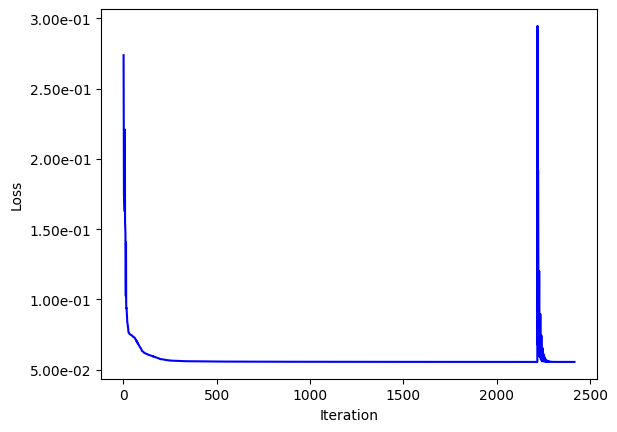

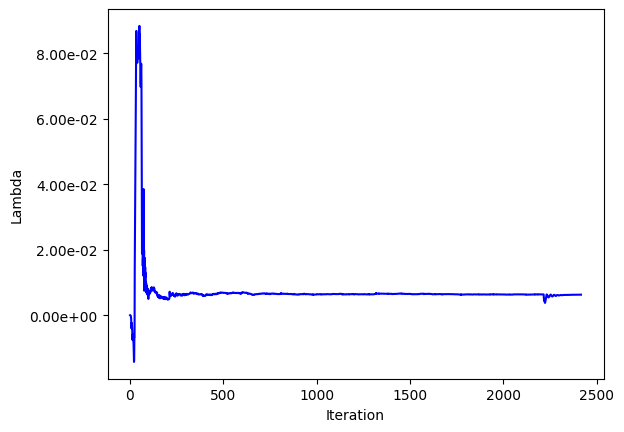

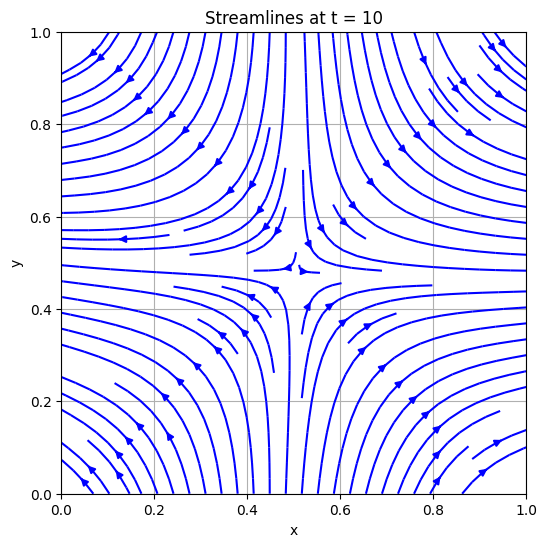

In [ ]:
model.train(100, 0)

# Test data generation
t_samples = np.arange(7.0, 10.0+delta_t, delta_t)
x_samples = np.arange(0, 1.0 + delta_x, delta_x)
y_samples = np.arange(0, 1.0 + delta_x, delta_x)
data_test = generate_data(t_samples, x_samples, y_samples, lam=0.01)

# Model predictions
# inputs = torch.tensor(data_test[:, :3], dtype=torch.float32, requires_grad=False).to(device)
u_pred, v_pred, _ = model.predict(data_test[:, :3])
# u_pred = pred_uvp[:, 0]
# v_pred = pred_uvp[:, 1]

u_test = torch.tensor(data_test[:, 3], dtype=torch.float32, requires_grad=False).to(device)
v_test = torch.tensor(data_test[:, 4], dtype=torch.float32, requires_grad=False).to(device)
# Calculate L2 error
mse_loss = torch.nn.MSELoss()
L2 = mse_loss(u_pred, u_test) + mse_loss(v_pred ,v_test)

print("L2 =", L2)
print("lambda = ", model.lambda_1)

# Plot loss history
plot_loss(model.losses_hist, ylabel='Loss')

# Plot lambda history
plot_loss(model.lambda_hist, ylabel='Lambda')

# Plot streamlines
plot_streamlines(model, delta_x, t_value=10)

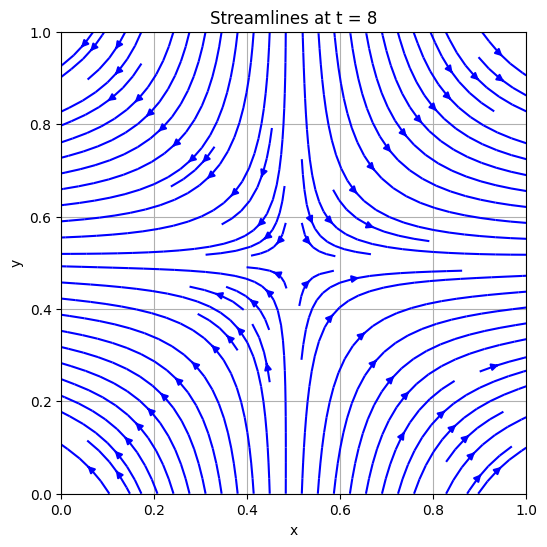

In [ ]:
# Plot streamlines
plot_streamlines(model, delta_x, t_value=8)

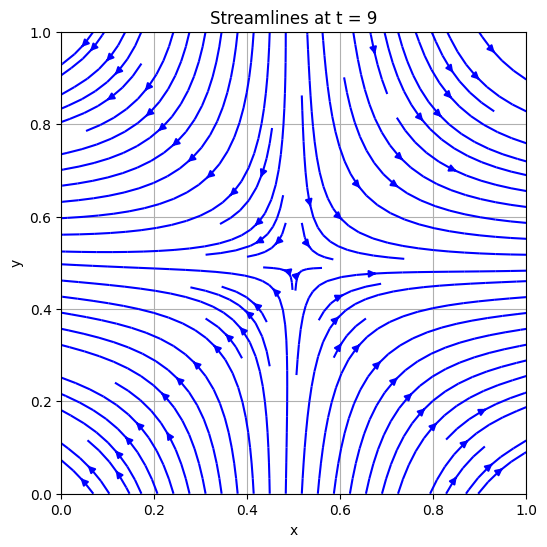

In [ ]:
plot_streamlines(model, delta_x, t_value=9)